# Proyecto


En este proyecto vamos a hacer machine learning aplicado al ámbito medico ,específicamente diagnostico medico.
Vamos a crear una aplicación que ayuda a diagnosticar si un tumor de seno es cancerígeno (maligno) o no (benigno)   .
Para lograr esto vamos a utilizar un set de datos recopilado por diversos médicos , el cual contiene características de tumores de seno y el diagnostico final . Este es un problema de clasificación binaria ya que solo tenemos dos clases(maligno o benigno), se va a implementar regresión logística para obtener la probabilidad de que el tumor sea maligno.

<img src="images/ai_cancer.png" width="300">

Según lo visto en la clase en este proyecto el estudiante hará  todo el proceso de entrenamiento, evaluación y selección del modelo de machine learning(pasos 1 al 5 del diagrama de flujo de ejemplo) ,luego de seleccionar el mejor va a exportar el modelo (como fue explicado en la clase deployment/despliegue de modelos y va a entregarlo al profesor) ya que  este será utilizado dentro de una aplicación móvil (desarrollada por el profesor, paso 6 del diagrama )


<img src="images/diagrama.png" width="700">

In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import datetime
import helper
import math

## Registro de Experimentos
En machine learning y ciencia de datos es importante tener un registro de los resultados de cada experimento realizado, así como la configuración del sistema(tal como learning-rate, numero de iteraciones, cantidad de observaciones y features, etc) que llevo a determinados resultados, esto porque el proceso puede llegar a ser muy iterativo y nos es útil saber en todo momento que caso tuvo los mejores resultados. Por esta razón en este proyecto utilizamos una bitácora o log-book científico en el cual tenemos la configuración de nuestros modelos y los resultados(métricas de evaluación) de cada uno.

In [8]:
log_book = helper.load_log_book()

Una vez la bitacora contenga informacion ,puedes consultarla en cualquier celda usando:

helper.print_log_book(log_book)

Para guardar la bitacora (una vez has capturado el resultado de los experimentos que realizaremos) usaremos el siguiente codigo(hay mas detalles mas adelante)

helper.guardar_log_book(log_book)

## Carnet estudiante

 La aplicación móvil resultante tendrá un modelo por estudiante, por lo cual es importante identificar a que estudiante pertenece cada modelo, por esta razón  en el proceso de exportar el modelo el archivo resultante tendrá en su nombre el carnet del estudiante. 
 
 En una variable deben ingresar su numero de carnet, para que al exportar el modelo el archivo se llame `carnet+"model.csv"`. Por ejemplo 200818835model.csv

In [325]:
carnet = "20150066"

## Breast Cancer Data Set

El dataset que usaremos contiene varias características(features) , más adelante encontraras instrucciones de cómo trabajar con estas. En el siguiente enlace puedes acceder a mayor información y detalles del dataset.

[Link al set de datos](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer)

#### Data Set Information:

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. A few of the images can be found at [Web Link] 

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes. 

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34]. 

In [10]:
data = load_breast_cancer()

Este es un problema de clasificacion binario por que que existen solo dos posibles valores(predecimos tumores cancerigenos de seno)

In [11]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

El data set tiene varios features, por lo  que debemos experimentar con diferentes features y analizar los resultados, en esta celda vamos a imprimir los nombres de las features que poseemos.

En este [link](https://goo.gl/U2Uwz2) podemos encontrar mas información sobre las features.

Nota: Aunque a lo largo del proyecto, usaremos distintas features para entrenar diversos modelos y entender cómo funciona el proceso de ML y el impacto del uso de diversas features, en el resultado final (el modelo que será exportado e integrado a la aplicación móvil) solo usaremos las primeras 5 features.



In [12]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

muestra de las primeras 5 labels/etiquetas

In [13]:
data.target[0:5]

array([0, 0, 0, 0, 0])

las features para estos 5 casos de ejemplo

In [14]:
data.data[0:5,]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

# Implementación de Regresión Logística 

## Hipótesis
Función Sigmoid:

$sig(t) = {\frac {1} {1 + e^{-t}}}$

Combinamos la función sigmoid/lógistica con la  hipótesis conocida (aprendida en regresión lineal) y tenemos la nueva hipótesis para clasificación con regresión lógistica:

$z = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \ldots + \theta_{n}x_{n}$

$g(z) = {\frac {1} {1 + e^{-z}}}$

** Hipótesis para clasificación con regresión logística: **

$h_{\theta}(x) = {\frac {1} {1 + e^{-(\theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \ldots + \theta_{n}x_{n})}}}$

In [15]:
## Sigmoid 

def sigmoid(z):
    ### INICIO: TU CODIGO AQUI:  (~1 linea)###
    s = 1/(1+np.exp(-z))
    ### FIN ##
    
    return s

In [16]:
### Validando nuestra funcion sigmoid
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


#### Resultados esperados

**sigmoid(0)** = 0.5

**sigmoid(9.2)** = 0.999898970806


Implementado la hipótesis/modelo para clasificación con regresión logística

** Hipótesis para clasificación con regresión logística: **

$h_{\theta}(x) = {\frac {1} {1 + e^{-(\theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \ldots + \theta_{n}x_{n})}}}$

In [17]:
def get_hipotesis(features, theta_values):
    ## Calculo de la hipotesis de froma vectorizada,producto punto entre el vector de features y el vector de parametros theta ##
    z = features.dot(theta_values)
    
    ### INICIO: TU CODIGO AQUI:  (~1 linea)###
    h = 1/(1+np.exp(-z))
    ### FIN ##
    
    return h

# Métricas de evaluación

Tal como lo vimos en la clase 22: evaluación , utilizamos diversas métricas para evaluar y reportar la exactitud y rendimiento de nuestros modelos de machine learning. En clasificación usamos el costo: cross-entropy para entrenar, pero evaluamos y reportamos diversas métricas mas .

## Costo

El proceso de gradient descent busca minimizar la siguiente función de costo en función de los parámetros theta, y así encontrar los parámetros que producen una hipótesis optima. 

El costo mide que tan buena o mala es una hipótesis por lo cual esperamos que este disminuya durante el entrenamiento.

$J(\Theta) = - {\frac {1}{m}}\sum _{i=1}^{m} y \log(h(x)) + (1-y)\log(1-h(x))$

Utiliza la funcion log de numpy, Ejemplo:
`np.log(y)`

In [302]:
def costo(X, theta_vector, y):
    m = len(y)
    
    ### INICIO: TU CODIGO AQUI:  (~2 lineas)###
    y_hat = get_hipotesis(X,theta_vector)
    
    costo = y*(np.log(y_hat+(1-y)*np.log(1-y_hat)))

    ### FIN ##
    
    return costo

## Accuracy Score

Implementa la funcion de accuracy utlizando sklearn(puedes utilizar como referencia la clase 22: evaluación )

In [68]:
def accuracy(X, theta_vector, y):

    hipotesis = get_hipotesis(X, theta_vector)
    
    # Convertimos el resultado probabilistico a deterministico (0 1)
    y_pred = [1 if (y >= 0.5) else 0 for y in hipotesis]
    
    ### INICIO: TU CODIGO AQUI:  (~1 linea)###
    acc_score = accuracy_score(y, y_pred)
    ### FIN ##
    
    return acc_score

## F1 Score

Implementa la funcion de f1_score utlizando sklearn(puedes utilizar como referencia la clase 22: evaluación )

In [78]:
def f1(X, theta_vector, y):

    hipotesis = get_hipotesis(X, theta_vector)

    # Convertimos el resultado probabilistico a deterministico (0 1)    
    y_pred = [1 if (y >= 0.5) else 0 for y in hipotesis ]
    
    ## INICIO: TU CODIGO AQUI:  (~1 linea)###
    f1 = f1_score(y, y_pred)
       ### FIN ##
    
    return f1

## Precision Score

Implementa la funcion de precision_score utlizando sklearn(puedes utilizar como referencia la clase 22: evaluación )

In [74]:
def precision(X, theta_vector, y):

    hipotesis = get_hipotesis(X, theta_vector)

    # Convertimos el resultado probabilistico a deterministico (0 1)    
    y_pred = [1 if (y >= 0.5) else 0 for y in hipotesis ]
    
    ## INICIO: TU CODIGO AQUI:  (~1 linea)###
    precision = precision_score(y, y_pred)
    ### FIN ##
    
    return precision

## Recall Score

Implementa la funcion de recall_score utlizando sklearn(puedes utilizar como referencia la clase 22: evaluación )

In [76]:
def recall(X, theta_vector, y):

    hipotesis = get_hipotesis(X, theta_vector)

    # Convertimos el resultado probabilistico a deterministico (0 1)    
    y_pred = [1 if (y >= 0.5) else 0 for y in hipotesis ]
    
    ## INICIO: TU CODIGO AQUI:  (~1 linea)###
    reacall = recall_score(y, y_pred)
    ### FIN ##
    
    return recall

# Pre-procesamiento

En Machine learning, la fase de pre-procesamiento(incluyendo feature engineering) de datos puede llegar a abarcar el 70% o más del tiempo de un proyecto , pero este es un tema que se profundiza en otros cursos del área de ciencia de datos por lo cual en este proyecto solo vamos a realizar como pre-procesamiento una normalización de features.

### Estandarización o Z-score Normalizacion 

El objetivo de la normalización es ayudar a gradient descent a encontrar el mínimo del costo mas rápido y fácilmente , esto se logra a través de convertir las features de manera que tengan media = 0 y desviación estándar de 1 , similar a una distribución de probabilidad normal(gaussiana).

Lo calculamos utilizando:

$z = {\frac {x - \mu} {\sigma}}$

Donde $\mu$ es la media y $\sigma$ es la desviacion estandard

##### Comentario opcional:
el Z-score en el nombre concuerda con el uso de "z-scores" en estadística cuando se hace estadística inferencial(prueba de hipótesis e intervalos de confianza)

Implementa la funcion de normalizacion sin utlizar sklearn solo puedes utilizar numpy.

Para utilizar la columna de features, utilizamos `features[:,i]`

In [23]:
def normalizar(features):
    std = 1
    media = 0
    
    # Utilizamos el ciclo, para normalizar cada feature(una iteracion por feature)
    for i in list(range(0, features.shape[1])):
        ### INICIO: TU CODIGO AQUI:  (~3 lineas)###
        std = np.std(features)
        media = np.mean(features)
        features[:,i] = (features[:,i] - media) / std;
        ### FIN ##
    return features

## Prediccion

Una vez entrenado, el modelo de ML se utiliza para realizar predicciones ,en este proyecto realizaremos predicciones en un train y un test set(no usaremos cross-validation set)  .Una  vez exportado y entregado el modelo al profesor, el modelo realizara predicciones dentro de una aplicación móvil . 

La siguiente función la vamos a utilizar para realizar predicciones a lo largo del proyecto(y así poder medir contra los datos reales para realizar evaluación), no hay que cambiar nada del código, solo ejecuta la celda.

In [24]:
def prediccion(x, theta_vector, normalizar_valores):
    numero_features = x.shape[1] + 1
    
    if (normalizar_valores):
        x = normalizar(x)
    
    x_features = np.ones((x.shape[0], numero_features))
    x_features[:,:-1] = x

    
    y_hat = get_hipotesis(x_features, theta_vector)
    
    return np.array([1 if (y >= 0.5) else 0 for y in y_hat])

## Gradient Descent

Gradient descent es el algoritmo o método de optimización matemática que nos permite realizar el “entrenamiento” de nuestro modelos, ya que minimiza el costo y nos devuelve los parámetros del modelo óptimos.

En la siguiente celda, debes implementar gradient descent tal como visto en clase y practicado en las tareas .

Lo definimos e implementamos dentro de una función de Python para que podamos ejecutarlo(“llamarlo”) múltiples veces con distintos parámetros, sin tener que volver a programarlo cada vez , esto nos será útil para experimentar y entrenar varios modelos.

Repetir{

$\theta_{j} := \theta _{j} - \alpha {\frac {1}{m}} \sum _{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_{j}$

}
        
Simultaneamente para cada $j = 0,\ldots,n $

In [315]:
def gradient_descent(X, y, theta_vector, alpha, iterations, X_test, y_test, nombre_modelo):
    global log_book
    m = len(y)  #numero de ejemplos de entrenamiento

    ## Las siguientes 3 lineas de codigo crean listas vacias para almacenar el costo y accuracy obtenido en cada iteracion
    ## Se espera que el costo disminuya y el accuracy aumente
    cost_vect = []
    accuracy_vect = []
    accuracy_vect_test = []
    
    for iteration in range(iterations):
        '''
        IMPLELEMTA TU CODIGO AQUI, llama a la funcion para calcular la hipotesis,es decir calcular h(x)
        que se implemento mas arriba. Parametros matriz de features X y el vector
        con los valores Theta (~1 linea)
        '''
        hipotesis = get_hipotesis(X, theta_vector)


        theta_vector_temp = [] # vector que guarda los parametros theta temporales
        
        # Utilizamos un ciclo para realizar la actualizacion de gradient descent una vez para cada parametro
        # En cada iteracion "i" guarda el numero de parametro theta, y la varaible "theta" guarda el parametro como tal
        for i, theta in enumerate(theta_vector):
            '''
            IMPLELEMTA TU CODIGO AQUI, adentro de este ciclo vamos a calcular
            elnuevo valor de Theta[i], utilizando la formula de la celda de arriba
            Recuerda que para multiplicar por utilizamos X[:,i]  (~1 linea)
            '''
            nuevo_theta = theta-alpha*(1/(int(m))*np.sum(np.subtract(hipotesis,y)*X[:,i]))

            ### aqui agregamos el nuevo valor the theta[i] a un vector temporal
            theta_vector_temp.append(nuevo_theta)


        ## Actualizamos el vector theta con los nuevos valores
        theta_vector = theta_vector_temp

        # En las sigiuentes lineas calculamos las metricas de evaluacion en cada iteracion(aplicadas al train-set)
        '''
        IMPLEMENTA TU CODIGO AQUI, llama a la funcion de costo (~1 linea)
        '''
        cost = costo(X, theta_vector, y)
        
        '''
        IMPLEMENTA TU CODIGO AQUI, utiliza Accuracy que se definio arriba (~1 linea)
        '''
        y_pred = [1 if (y >= 0.5) else 0 for y in hipotesis]
        acc_score = accuracy_score(y, y_pred, normalize=True)
        
        '''
        IMPLEMENTA TU CODIGO AQUI, utiliza f1 score que se definio arriba (~1 linea)
        '''
        f1_training = f1(X, theta_vector, y)

        '''
        IMPLEMENTA TU CODIGO AQUI, utiliza precision score que se definio arriba (~1 linea)
        '''
        precision_training = precision(X, theta_vector, y) 
        
        '''
        IMPLEMENTA TU CODIGO AQUI, utiliza recall score que se definio arriba (~1 linea)
        '''
        recall_training = recall(X, theta_vector, y)
        
        
        ## En las siguientes lineas calculamos las metricas de evaluacion aplicadas al test-set, este codigo no hay que cambiarlo ####
        y_predict = prediccion(X_test, theta_vector, True)
        acc_test = accuracy_score(y_predict, y_test)
        accuracy_vect_test.append(acc_test)
        f1_score_test = f1_score(y_predict, y_test)
        precision_test = precision_score(y_test, y_predict)
        recall_test = recall_score(y_test, y_predict)
        
        ## Guardando el valor del costo para graficarlo, este codigo no hay que cambiarlo ##
        cost_vect.append(cost)
        accuracy_vect.append(acc_score)
        
        n = 300 ### Ingresa aqui cada cuantas iteraciones quieres que se imprima el valor de las metricas ###
        
        ## Este codigo no hay que modificarlo ##
        if(iteration % n == 0):
            print('#####################')
            print('TRAINING: [Iteracion: ', iteration,' Costo: ', cost, \
                  ' Accuracy:', acc_score,' F1 Score:',f1_training, \
                  'Precision training:', precision_training, 'Recall training:', recall_training,']')
            print('TEST: [Iteracion: ', iteration,'Accuracy:', acc_test, \
                  ' F1 Score:', f1_score_test, 'Precision Test:', precision_test,'Recall Test:', recall_test,']')
        
    ## Log book, este codigo no hay que cambiarlo, sirve para guardar en la bitacora los resultados del experimento ##
    nombre_modelo = nombre_modelo + '_'+datetime.datetime.now().strftime("%d%H%M%f")
    numero_features = X.shape[1] - 1
    experiment = np.array([nombre_modelo, numero_features, m, alpha, iterations, accuracy_vect[-1], \
                           accuracy_vect_test[-1], f1_score_test, precision_test, \
                           recall_test,theta_vector], dtype=object)
    log_book = np.vstack([log_book, experiment])
        
    return theta_vector, cost_vect, accuracy_vect,accuracy_vect_test


## Dividimos la data en training y test set

Tal como visto en la clase 23, nos sirve para evaluar objetivamente el rendimiento de nuestros modelos en datos que nunca ha visto durante su entrenamiento

In [285]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, stratify=data.target, random_state=42)

In [286]:
X_train.shape

(426, 30)

# Entrenamiento

## Features a utilizar
A continuación, vamos a entrenar varios modelos, vamos a utilizar las funciones que creamos previamente.
Es importante experimentar con diferentes features,diverso tamaño del training set, y diversos hyper-parametros(learning rate e iteraciones)

En este proyecto como máximo vamos a utilizar 5 features(pero en algunos experimentos usaremos menos) de manera obligatoria, pero de forma opcional se recomienda experimentar con más y diversas combinaciones ,esto para practicar y obtener experiencia con ML. 

También vamos a utilizar diferente número de ejemplos en el set de datos, diferente número de iteraciones y diferente learning rate . Todas estas distintas configuraciones serán almacenadas en el log-book(bitácora) automáticamente .

En este proyecto solo vamos a utilizar las primeras 5 features  en este orden:

`['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness']`

La razón por las que usaremos estas 5 features específicamente(y en este orden) en el modelo final(el que será exportado) es que estas features son las que serán utilizadas en la aplicación móvil en la cual integraremos el modelo(y tendremos en la interfaz de usuario de la aplicación componentes para ingresar valores para estas features),ero como se mencionó se recomienda experimentar y evaluar resultados con distintas features y distinto número  de ellas .

## Descripcion del entrenamiento
El entrenamiento de cada modelo se compone básicamente de tres pasos, sampleo bootstrap, escoger las features y ejecutar el entrenamiento llamando a la función de gradient descent que ya creamos.

En el primer paso vamos a utilizar la función resample para hacer un sampleo del set de datos de entrenamiento, debemos definir el numero de samples que queremos utilizar.

En el segundo paso, en un arreglo vamos a definir el nombre de las features que queremos utilizar para entrenar el modelo.
En el tercer paso ejecutamos la función gradient descent.

Por ultimo vamos a obtener el accuracy del modelo y vamos a imprimir la matriz de confusión, imprimiremos el precisión y el recall del modelo para entender mejor los resultados y tener una mejor idea de que tan bien clasifica nuestro modelo.

## Entrenamiento modelo 1

#### Sampleo bootstrap

In [294]:
X_train_m1, Y_train_m1 = resample(X_train, y_train, n_samples = 460)

### Filtrar Features
Solo seleccionar los features

In [304]:
'''
Ingresa en la lista el nombre de las fatrues que quieres utlizar en este modelo (~1 linea)
'''
features_filtro = ['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness']

In [310]:
X_train_m1 = helper.fitrar_nombre(X_train_m1,data.feature_names,features_filtro)
X_test_features = helper.fitrar_nombre(X_test,data.feature_names,features_filtro)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 5 but corresponding boolean dimension is 30

In [306]:
X_train_m1.shape

(460, 5)

In [307]:
X_test_features.shape

(143, 5)

In [308]:
## Numero de iteracions ##
iterations = 2000  # Define el numero de iteraciones #

## Alpha ##
alpha = 0.01 # Define el valor de alpha #

#### No hay que cambiar el codigo despues de esta linea #####
## Numero de feautres ##
numero_features = X_train_m1.shape[1] + 1

## Creamos un vector donde se almacenan los valores de Theta,
## lo inicializamos con numeros aleatorios
theta_vector = np.random.rand(numero_features)

## Normaliza las features de X_train_features (~1 linea) ##
X_train_m1 = normalizar(X_train_m1)

# Creando la Matriz X de features, 
# utilizamos np.ones para agregar el valor constante '1' que es el bias o feature 0
X_train_features = np.ones((X_train_m1.shape[0], numero_features))
X_train_features[:,:-1] = X_train_m1

In [309]:
modelo_1_theta_values, cost_vect, acc_vect, acc_vect_test = \
gradient_descent(X_train_features, Y_train_m1, theta_vector, alpha, iterations, X_test_features, y_test, 'modelo_1')

C:\Users\Admin VDK\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


#####################
TRAINING: [Iteracion:  0  Costo:  [-0.59660798         nan -0.59425946         nan -0.53388773         nan
         nan         nan -0.70089653         nan -0.40888194 -0.64286072
         nan         nan -0.63052361         nan -0.56796439 -0.49401282
 -0.62562623 -0.60962109         nan -0.54928233 -0.5096284          nan
         nan -0.53310627 -0.50046052         nan -0.758161           nan
         nan         nan         nan         nan -0.53876829         nan
 -0.56382193 -0.54270236 -0.62459869 -0.42866129         nan         nan
 -0.5096284          nan -0.60511711         nan -0.47614276 -0.63934991
 -0.58399841 -0.73624463 -0.65217662 -0.54270236 -0.54536645 -0.61734363
         nan         nan         nan -0.46074014         nan -0.70585654
         nan         nan         nan -0.70235769 -0.62459869 -0.59308651
 -0.49085573         nan -0.56423332 -0.60533104         nan -0.5621258
 -0.65025474         nan -0.5805448  -0.68754622 -0.65646841         

C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#####################
TRAINING: [Iteracion:  300  Costo:  [-0.60892043         nan -0.61098237         nan -0.65100969         nan
         nan         nan -0.55181581         nan -0.75745283 -0.58216656
         nan         nan -0.59338389         nan -0.62454969 -0.68388102
 -0.59833846 -0.59920918         nan -0.63982555 -0.66564383         nan
         nan -0.65851681 -0.67429686         nan -0.53015172         nan
         nan         nan         nan         nan -0.65048239         nan
 -0.62948545 -0.64470208 -0.59085006 -0.74491776         nan         nan
 -0.66564383         nan -0.60170715         nan -0.68698245 -0.58648576
 -0.61709401 -0.53640958 -0.57803552 -0.64470208 -0.64761599 -0.59559507
         nan         nan         nan -0.69862598         nan -0.55043258
         nan         nan         nan -0.54792629 -0.59085006 -0.61153133
 -0.68602225         nan -0.62637498 -0.60212136         nan -0.63090815
 -0.58020336         nan -0.61919293 -0.56197685 -0.57365793      

#####################
TRAINING: [Iteracion:  900  Costo:  [-0.37826401         nan -0.38198254         nan -0.46847854         nan
         nan         nan -0.27164073         nan -0.74153375 -0.32526872
         nan         nan -0.34213795         nan -0.41334458 -0.54348774
 -0.35025818 -0.36091974         nan -0.44391302 -0.50576874         nan
         nan -0.47804262 -0.52755839         nan -0.23382731         nan
         nan         nan         nan         nan -0.46459323         nan
 -0.42185384 -0.45392111 -0.34330078 -0.69821289         nan         nan
 -0.50576874         nan -0.36585921         nan -0.56638344 -0.33179331
 -0.39467747 -0.24574439 -0.31694434 -0.45392111 -0.4563603  -0.35250052
         nan         nan         nan -0.59586278         nan -0.26829437
         nan         nan         nan -0.26772263 -0.34330078 -0.38332773
 -0.54936381         nan -0.41957717 -0.36753815         nan -0.42466128
 -0.32000301         nan -0.39926684 -0.28567494 -0.31107131      

#####################
TRAINING: [Iteracion:  1500  Costo:  [-0.27956129         nan -0.28366434         nan -0.38634978         nan
         nan         nan -0.16861395         nan -0.76047335 -0.22202745
         nan         nan -0.23913824         nan -0.32033298 -0.48195877
 -0.24757276 -0.26063241         nan -0.35630511 -0.43413841         nan
         nan -0.39678616 -0.46239933         nan -0.13365674         nan
         nan         nan         nan         nan -0.38098754         nan
 -0.32997264 -0.36837038 -0.24133504 -0.69539069         nan         nan
 -0.43413841         nan -0.26608956         nan -0.51556867 -0.22857129
 -0.29814696 -0.14454268 -0.21329295 -0.36837038 -0.37051288 -0.25123545
         nan         nan         nan -0.55575285         nan -0.16530585
         nan         nan         nan -0.16526894 -0.24133504 -0.28522143
 -0.48985686         nan -0.3279986  -0.2680057          nan -0.33325291
 -0.216298           nan -0.3034538  -0.18164189 -0.20760248     

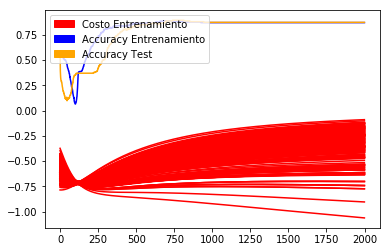

In [249]:
## Funcion para graficar el costo y  accuracy durante cada iteracion ##
helper.training_graph(cost_vect, acc_vect, acc_vect_test)

### Accuracy y Matriz de confusion Training Set

![alt text](https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

In [250]:
y_hat = get_hipotesis(X_train_features, modelo_1_theta_values)
y_predict = np.array([1 if (y > 0.5) else 0 for y in y_hat])

print('Accuracy:', accuracy_score(Y_train_m1,y_predict) * 100 ,'%')
print()
print('Matriz de confusion')
confusion_matrix(Y_train_m1, y_predict )

Accuracy: 87.17391304347825 %

Matriz de confusion


array([[130,  49],
       [ 10, 271]], dtype=int64)

#### Accuracy con el Test set

In [251]:
y_predict = prediccion(X_test_features, modelo_1_theta_values, True)

In [252]:
print('Accuracy:',accuracy_score(y_test, y_predict)* 100 ,'%')

Accuracy: 87.41258741258741 %


#### Matriz de confusion Test Set

In [253]:
confusion_matrix(y_test, y_predict)

array([[38, 15],
       [ 3, 87]], dtype=int64)

In [254]:
print('precision: ',precision_score(y_test, y_predict))

print('recall: ', recall_score(y_test, y_predict))

precision:  0.8529411764705882
recall:  0.9666666666666667


## Entrenamiento modelo 2

#### Sampleo bootstrap

In [154]:
'''
Ingresa en la lista el nombre de las fatrues que quieres utlizar en este modelo (~1 linea)
'''
X_train_m2, Y_train_m2 = resample(X_train, y_train, n_samples = 400)

### Filtrar Features
Solo seleccionar los features

In [155]:
features_filtro = ['mean perimeter', 'mean area','mean smoothness']

In [156]:
X_train_m2 = helper.fitrar_nombre(X_train_m2,data.feature_names,features_filtro)
X_test_features = helper.fitrar_nombre(X_test,data.feature_names,features_filtro)

In [157]:
## Numero de iteracions ##
iterations = 1000  # Define el numero de iteraciones #

## Alpha ##
alpha = 0.05 # Define el valor de alpha #

#### No hay que cambiar el codigo despues de esta linea #####
## Numero de feautres ##
numero_features = X_train_m2.shape[1] + 1

## Creamos un vector donde se almacenan los valores de Theta,
## lo inicializamos con numeros aleatorios
theta_vector = np.random.rand(numero_features)

## Normaliza las features de X_train_features (~1 linea) ##
X_train_m2 = normalizar(X_train_m2)

# Creando la Matriz X de features, 
# utilizamos np.ones para agregar el valor constante '1' que es el bias o feature 0
X_train_features = np.ones((X_train_m2.shape[0], numero_features))
X_train_features[:,:-1] = X_train_m2

In [162]:
## Llama a la funcion de gradient descent, recurda definir un nombre diferente para el modelo (~1 linea) ##
modelo_2_theta_values, cost_vect, acc_vect, acc_vect_test = \
gradient_descent(X_train_features, Y_train_m2, theta_vector, alpha, iterations, X_test_features, y_test, 'modelo_2')
### FIN ##

C:\Users\Admin VDK\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log


#####################
TRAINING: [Iteracion:  0  Costo:  [-0.48696167 -0.48517485         nan         nan         nan -0.38478495
 -0.23526599 -0.29127318         nan -0.35275959 -0.52879676         nan
 -0.36112488         nan -0.49489123 -0.4342206  -0.27431826 -0.54156875
 -0.32555762 -0.43847276 -0.32994088 -0.30569257 -0.35831221 -0.32463336
 -0.53052897 -0.27431826 -0.43721131         nan -0.31789169         nan
         nan         nan         nan -0.28910431 -0.45592268 -0.4342206
 -0.37039199         nan         nan -0.45920568 -0.31545338 -0.29337167
 -0.44081107 -0.43027854 -0.35213667         nan -0.32994088 -0.30895339
 -0.39187684         nan -0.54156875 -0.25520831 -0.34585192 -0.36138963
 -0.45595172 -0.26142946 -0.48517485 -0.24678759         nan         nan
 -0.40643193 -0.49489123 -0.61461866         nan         nan         nan
 -0.48861586 -0.34085537         nan         nan         nan -0.39387926
 -0.42584497 -0.38983935 -0.41103544 -0.23302982 -0.4807322  -0.32045

C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#####################
TRAINING: [Iteracion:  300  Costo:  [-0.20573146 -0.19100611         nan         nan         nan -0.31981595
 -0.67333395 -0.48846971         nan -0.35315957 -0.1678814          nan
 -0.34938974         nan -0.2005106  -0.26037377 -0.52529616 -0.16802149
 -0.43328058 -0.24982042 -0.40483537 -0.46316693 -0.35700969 -0.39666436
 -0.17083232 -0.52529616 -0.2466089          nan -0.43422666         nan
         nan         nan         nan -0.5009541  -0.22714604 -0.26037377
 -0.33681177         nan         nan -0.22804779 -0.41560124 -0.47770002
 -0.23473224 -0.25803696 -0.36401494         nan -0.40483537 -0.44966735
 -0.29619509         nan -0.16802149 -0.58799918 -0.3729502  -0.34589567
 -0.22704604 -0.57443001 -0.19100611 -0.61663522         nan         nan
 -0.28579759 -0.2005106  -0.12556047         nan         nan         nan
 -0.20797707 -0.36387972         nan         nan         nan -0.3017135
 -0.25541091 -0.31409099 -0.27513856 -0.67976927 -0.20779695 -0.430

#####################
TRAINING: [Iteracion:  900  Costo:  [-0.07011516 -0.06280225         nan         nan         nan -0.16651216
 -0.70227819 -0.38643035         nan -0.20676617 -0.04794967         nan
 -0.20001119         nan -0.06654424 -0.11050956 -0.44760349 -0.04705817
 -0.2993886  -0.10285321 -0.26737692 -0.34566031 -0.20791713 -0.26202686
 -0.04910167 -0.44760349 -0.10105724         nan -0.30517847         nan
         nan         nan         nan -0.40341831 -0.08613783 -0.11050956
 -0.18555249         nan         nan -0.08616908 -0.28719569 -0.37199804
 -0.09308007 -0.10974288 -0.21705039         nan -0.26737692 -0.32836053
 -0.14589136         nan -0.04705817 -0.55165818 -0.22813798 -0.19684562
 -0.08606035 -0.5266918  -0.06280225 -0.60268765         nan         nan
 -0.13437221 -0.06654424 -0.0270735          nan         nan         nan
 -0.07111095 -0.22190506         nan         nan         nan -0.14958474
 -0.10893369 -0.16036732 -0.12552247 -0.71530849 -0.07196942 -0.29

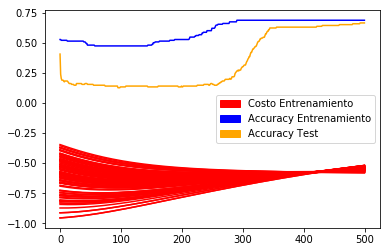

In [97]:
## Funcion para graficar el costo y  accuracy durante cada iteracion ##
helper.training_graph(cost_vect, acc_vect, acc_vect_test)

#### Accuracy con el Test set [Modelo 2]

In [163]:
y_predict = prediccion(X_test_features, modelo_2_theta_values, True)

In [164]:
print('Accuracy:',accuracy_score(y_test, y_predict)* 100 ,'%')

Accuracy: 87.41258741258741 %


#### Matriz de confusion Test Set [Modelo 2]

In [165]:
confusion_matrix(y_test, y_predict)

array([[38, 15],
       [ 3, 87]], dtype=int64)

In [166]:
print('precision: ',precision_score(y_test, y_predict))

print('recall: ', recall_score(y_test, y_predict))

precision:  0.8529411764705882
recall:  0.9666666666666667


## Entrenamiento modelo 3

#### Sampleo bootstrap

In [186]:
X_train_m3, Y_train_m3 = resample(X_train, y_train, n_samples = 460)

### Filtrar Features
Solo seleccionar los features

In [187]:
'''
Ingresa en la lista el nombre de las fatrues que quieres utlizar en este modelo (~1 linea)
'''
features_filtro = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']

In [188]:
X_train_m3 = helper.fitrar_nombre(X_train_m3,data.feature_names,features_filtro)
X_test_features = helper.fitrar_nombre(X_test,data.feature_names,features_filtro)

In [189]:
## Numero de iteracions ##
iterations = 1500  # Define el numero de iteraciones #

## Alpha ##
alpha = 0.02 # Define el valor de alpha #

#### No hay que cambiar el codigo despues de esta linea #####
## Numero de feautres ##
numero_features = X_train_m3.shape[1] + 1

## Creamos un vector donde se almacenan los valores de Theta,
## lo inicializamos con numeros aleatorios
theta_vector = np.random.rand(numero_features)

## Normaliza las features de X_train_features (~1 linea) ##
X_train_m3 = normalizar(X_train_m3)

# Creando la Matriz X de features, 
# utilizamos np.ones para agregar el valor constante '1' que es el bias o feature 0
X_train_features = np.ones((X_train_m3.shape[0], numero_features))
X_train_features[:,:-1] = X_train_m3

In [190]:
## Llama a la funcion de gradient descent, recurda definir un nombre diferente para el modelo (~1 linea) ##
modelo_3_theta_values, cost_vect, acc_vect, acc_vect_test = \
gradient_descent(X_train_features, Y_train_m3, theta_vector, alpha, iterations, X_test_features, y_test, 'modelo_3')
### FIN 

C:\Users\Admin VDK\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log


#####################
TRAINING: [Iteracion:  0  Costo:  [-0.35766411 -0.48415491 -0.18060991 -0.3068182  -0.34921183         nan
 -0.31705028 -0.23986299         nan         nan         nan         nan
 -0.27499253 -0.44155758 -0.31859145 -0.28079991 -0.23594444 -0.20380504
         nan         nan -0.36306733 -0.31420503 -0.36630273 -0.57365309
         nan         nan -0.25592216 -0.25209128 -0.32394144 -0.32198868
         nan -0.35868383 -0.22293886 -0.26348666         nan -0.29923898
 -0.23220845 -0.38919126 -0.49396467 -0.45163992 -0.30601291         nan
         nan -0.43278513 -0.52380309 -0.45429202 -0.3429475  -0.27442139
 -0.24569369 -0.23220845 -0.25819426         nan         nan -0.30872338
         nan -0.19474117 -0.37932327 -0.31705028 -0.30581817 -0.35993965
         nan -0.22273927         nan -0.19787311         nan -0.27442139
         nan -0.52041203 -0.52598169         nan -0.31420503 -0.19267509
         nan -0.30600956         nan -0.42150799 -0.18307419 -0.3067

#####################
TRAINING: [Iteracion:  600  Costo:  [-0.28949251 -0.1977634  -0.60275145 -0.34689477 -0.29843861         nan
 -0.33556497 -0.45432541         nan         nan         nan         nan
 -0.39102773 -0.22310414 -0.33220932 -0.38181636 -0.46144204 -0.53498522
         nan         nan -0.28458647 -0.33622858 -0.28342705 -0.15836702
         nan         nan -0.42334463 -0.43036379 -0.32567606 -0.327009
         nan -0.2893293  -0.49043516 -0.41020332         nan -0.35580082
 -0.4691362  -0.26222981 -0.19277466 -0.21818385 -0.34857201         nan
         nan -0.22925279 -0.17801313 -0.21551322 -0.30471711 -0.39160073
 -0.44090252 -0.4691362  -0.42143266         nan         nan -0.34324732
         nan -0.56075045 -0.2696275  -0.33556497 -0.3481892  -0.28736864
         nan -0.49128556         nan -0.55128571         nan -0.39160073
         nan -0.17986033 -0.17759291         nan -0.33622858 -0.56714794
         nan -0.34999054         nan -0.23651658 -0.59422519 -0.3467

#####################
TRAINING: [Iteracion:  1200  Costo:  [-0.18213168 -0.0960882  -0.60728294 -0.24670609 -0.19156721         nan
 -0.23357635 -0.3843796          nan         nan         nan         nan
 -0.30089298 -0.11779331 -0.22962634 -0.28855593 -0.39432744 -0.50156954
         nan         nan -0.17703533 -0.23361887 -0.17619765 -0.0664422
         nan         nan -0.34302943 -0.35139802 -0.22198726 -0.2230039
         nan -0.18204865 -0.4356537  -0.32608547         nan -0.25697804
 -0.40510203 -0.15443072 -0.09220223 -0.11369251 -0.24844246         nan
         nan -0.12327809 -0.08049928 -0.11110538 -0.19856442 -0.30106286
 -0.36619427 -0.40510203 -0.34089871         nan         nan -0.24161324
         nan -0.54216043 -0.16148276 -0.23357635 -0.24818246 -0.17955513
         nan -0.43842403         nan -0.52722364         nan -0.30106286
         nan -0.08195262 -0.08034853         nan -0.23361887 -0.54997311
         nan -0.2505541          nan -0.12979818 -0.59329414 -0.246

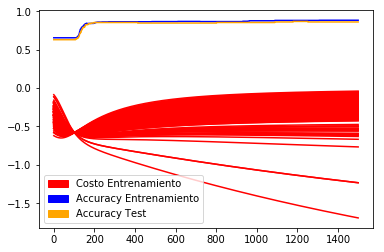

In [191]:
## Funcion para graficar el costo y  accuracy durante cada iteracion
helper.training_graph(cost_vect, acc_vect, acc_vect_test)

#### Accuracy con el Test set [Modelo 3]

In [192]:
y_predict = prediccion(X_test_features, modelo_3_theta_values, True)

In [193]:
print('Accuracy:',accuracy_score(y_test, y_predict)* 100 ,'%')

Accuracy: 86.01398601398601 %


#### Matriz de confusion Test Set [Modelo 3]

In [194]:
confusion_matrix(y_test, y_predict)

array([[35, 18],
       [ 2, 88]], dtype=int64)

In [195]:
print('precision: ',precision_score(y_test, y_predict))

print('recall: ', recall_score(y_test, y_predict))

precision:  0.8301886792452831
recall:  0.9777777777777777


## Entrenamiento modelo 4

#### Sampleo bootstrap

In [267]:
X_train_m4, Y_train_m4 = resample(X_train, y_train, n_samples = 460)

### Filtrar Features
Solo seleccionar los features

In [268]:
'''
Ingresa en la lista el nombre de las fatrues que quieres utlizar en este modelo (~1 linea)
'''
features_filtro = ['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness']

In [269]:
X_train_m4 = helper.fitrar_nombre(X_train_m4,data.feature_names,features_filtro)
X_test_features = helper.fitrar_nombre(X_test,data.feature_names,features_filtro)

In [270]:
## Numero de iteracions ##
iterations = 2000 # Define el numero de iteraciones #

## Alpha ##
alpha = 0.03 # Define el valor de alpha #

#### No hay que cambiar el codigo despues de esta linea #####
## Numero de feautres ##
numero_features = X_train_m4.shape[1] + 1

## Creamos un vector donde se almacenan los valores de Theta,
## lo inicializamos con numeros aleatorios
theta_vector = np.random.rand(numero_features)

## Normaliza las features de X_train_features (~1 linea) ##
X_train_m4 = normalizar(X_train_m4)

# Creando la Matriz X de features
X_train_features = np.ones((X_train_m4.shape[0], numero_features))
X_train_features[:,:-1] = X_train_m4

In [271]:
## Llama a la funcion de gradient descent, recurda definir un nombre diferente para el modelo (~1 linea) ##
modelo_4_theta_values, cost_vect, acc_vect, acc_vect_test = \
gradient_descent(X_train_features, Y_train_m4, theta_vector, alpha, iterations, X_test_features, y_test, 'modelo_4')

C:\Users\Admin VDK\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log
C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#####################
TRAINING: [Iteracion:  0  Costo:  [        nan         nan -0.59747523         nan -0.58413909         nan
 -0.61287578         nan         nan -0.63892686         nan         nan
 -0.61565088 -0.60341901 -0.69133669 -0.58655678 -0.65906784 -0.62116866
 -0.63493024         nan         nan -0.63521372         nan -0.62193955
         nan         nan -0.60456542         nan -0.6207925  -0.62071959
 -0.68464656 -0.6389117  -0.63946216 -0.60408759 -0.65456832         nan
 -0.54120521 -0.63649261 -0.65598734 -0.61707733 -0.65728781 -0.59104757
         nan -0.64881914         nan         nan -0.62453119         nan
 -0.60215153 -0.55937706         nan         nan -0.67737735 -0.63791133
 -0.67737735         nan         nan -0.61825355 -0.62966648 -0.4963101
         nan -0.67904919         nan         nan -0.59224958         nan
 -0.60559635         nan -0.56547032         nan -0.63475229 -0.58643182
 -0.68018039 -0.62458862 -0.68464656         nan -0.66038396         

#####################
TRAINING: [Iteracion:  600  Costo:  [        nan         nan -0.40628338         nan -0.46365501         nan
 -0.34134223         nan         nan -0.24339353         nan         nan
 -0.30399077 -0.41785388 -0.12691915 -0.42837865 -0.17643949 -0.26163916
 -0.25598376         nan         nan -0.24415432         nan -0.32560794
         nan         nan -0.36061052         nan -0.28208936 -0.24958922
 -0.12558446 -0.24140174 -0.22128081 -0.40303396 -0.17501581         nan
 -0.78350904 -0.27202137 -0.21918228 -0.28359916 -0.18324189 -0.45512652
         nan -0.19363759         nan         nan -0.27065794         nan
 -0.42188182 -0.56248958         nan         nan -0.13810388 -0.24606688
 -0.13810388         nan         nan -0.34298039 -0.2921791  -1.39611035
         nan -0.12913465         nan         nan -0.38538391         nan
 -0.34961561         nan -0.58564827         nan -0.28151146 -0.42279625
 -0.16585296 -0.27556022 -0.12558446         nan -0.16837852      

#####################
TRAINING: [Iteracion:  1200  Costo:  [        nan         nan -0.33183024         nan -0.4046783          nan
 -0.25518832         nan         nan -0.15337195         nan         nan
 -0.21535641 -0.3437586  -0.05756629 -0.36118073 -0.09485013 -0.17272386
 -0.16550362         nan         nan -0.15448902         nan -0.2367021
         nan         nan -0.27804091         nan -0.19263226 -0.16139403
 -0.05703022 -0.15171098 -0.13356351 -0.32636468 -0.09407309         nan
 -0.86309394 -0.18041582 -0.12998781 -0.19460193 -0.10028928 -0.39209185
         nan -0.1093963          nan         nan -0.18086301         nan
 -0.34889429 -0.54139078         nan         nan -0.06573679 -0.15592546
 -0.06573679         nan         nan -0.25589003 -0.20119643 -1.83305718
         nan -0.05960817         nan         nan -0.30893025         nan
 -0.26564818         nan -0.57046079         nan -0.18995325 -0.35416553
 -0.08531991 -0.18562718 -0.05703022         nan -0.0885677       

#####################
TRAINING: [Iteracion:  1800  Costo:  [        nan         nan -0.29814862         nan -0.37946479         nan
 -0.21658552         nan         nan -0.1166259          nan         nan
 -0.17658879 -0.31027392 -0.03556235 -0.3312509  -0.06520925 -0.13536333
 -0.12793554         nan         nan -0.11780374         nan -0.19727054
         nan         nan -0.24074227         nan -0.15425449 -0.12483446
 -0.0352646  -0.1151508  -0.09883556 -0.29158868 -0.06468352         nan
 -0.93271236 -0.14174556 -0.09507076 -0.15634507 -0.06973293 -0.3645646
         nan -0.07761504         nan         nan -0.14283302         nan
 -0.31596134 -0.54003582         nan         nan -0.04186026 -0.11899502
 -0.04186026         nan         nan -0.21686096 -0.16192922 -2.15498983
         nan -0.03724259         nan         nan -0.2743109          nan
 -0.22787286         nan -0.57307949         nan -0.15087362 -0.32352087
 -0.05701836 -0.14734055 -0.0352646          nan -0.06006526      

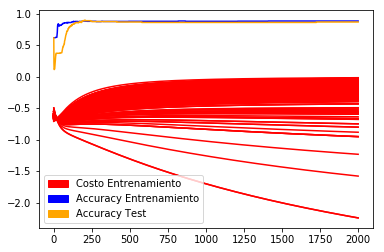

In [272]:
## Funcion para graficar el costo y  accuracy durante cada iteracion ##
helper.training_graph(cost_vect, acc_vect, acc_vect_test)

#### Accuracy con el Test set [Modelo 4]

In [273]:
y_predict = prediccion(X_test_features, modelo_4_theta_values, True)

In [274]:
print('Accuracy:',accuracy_score(y_test, y_predict)* 100 ,'%')

Accuracy: 86.7132867132867 %


#### Matriz de confusion Test Set [Modelo 4]

In [275]:
confusion_matrix(y_test, y_predict)

array([[37, 16],
       [ 3, 87]], dtype=int64)

In [276]:
print('precision: ',precision_score(y_test, y_predict))

print('recall: ', recall_score(y_test, y_predict))

precision:  0.8446601941747572
recall:  0.9666666666666667


## Entrenamiento modelo 5

#### Sampleo bootstrap

In [206]:
X_train_m5, Y_train_m5 = resample(X_train, y_train, n_samples = 460)

### Filtrar Features
Solo seleccionar los features

In [207]:
'''
Ingresa en la lista el nombre de las fatrues que quieres utlizar en este modelo (~1 linea)
'''
features_filtro = ['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness']

In [208]:
X_train_m5 = helper.fitrar_nombre(X_train_m5,data.feature_names,features_filtro)
X_test_features = helper.fitrar_nombre(X_test,data.feature_names,features_filtro)

In [209]:
## Numero de iteracions ##
iterations = 2000 # Define el numero de iteraciones #

## Alpha ##
alpha = 0.005 # Define el valor de alpha #

#### No hay que cambiar el codigo despues de esta linea #####
## Numero de feautres ##
numero_features = X_train_m5.shape[1] + 1

## Creamos un vector donde se almacenan los valores de Theta,
## lo inicializamos con numeros aleatorios
theta_vector = np.random.rand(numero_features)

## Normaliza las features de X_train_features (~1 linea) ##
X_train_m5 = normalizar(X_train_m5)

# Creando la Matriz X de features
X_train_features = np.ones((X_train_m5.shape[0], numero_features))
X_train_features[:,:-1] = X_train_m5

In [210]:
## Llama a la funcion de gradient descent, recurda definir un nombre diferente para el modelo (~1 linea) ##
modelo_5_theta_values, cost_vect, acc_vect, acc_vect_test = \
gradient_descent(X_train_features, Y_train_m5, theta_vector, alpha, iterations, X_test_features, y_test, 'modelo_5')

#####################
TRAINING: [Iteracion:  0  Costo:  [        nan -0.41159778 -0.41372289         nan         nan -0.5935538
 -0.39574077         nan -0.44658488 -0.54523855 -0.59445837 -0.53463761
 -0.4644826  -0.53155392 -0.43737671         nan         nan -0.43961923
 -0.51760216         nan -0.59867282 -0.54620238 -0.6569142  -0.49075916
         nan -0.58165377 -0.46139929         nan         nan -0.43389489
 -0.59968954 -0.51517778 -0.55129063 -0.56396784 -0.63820282 -0.62380052
 -0.5584046  -0.60672498         nan -0.5444325  -0.57458653         nan
 -0.61309803         nan -0.38006767 -0.45710232 -0.49293855 -0.59068647
 -0.6422935  -0.64233049 -0.59422889         nan -0.46050622         nan
         nan -0.59422889 -0.5935538  -0.62549735 -0.43448316 -0.520025
 -0.58129179 -0.53520013         nan         nan -0.54511907         nan
 -0.63820282         nan -0.51612212         nan         nan         nan
         nan -0.5030781          nan -0.53155392 -0.57839323         na

C:\Users\Admin VDK\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log
C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#####################
TRAINING: [Iteracion:  300  Costo:  [        nan -0.69794357 -0.69613            nan         nan -0.65046566
 -0.7037312          nan -0.68791969 -0.66269339 -0.64182753 -0.64797819
 -0.6838643  -0.65461703 -0.68278526         nan         nan -0.67275395
 -0.66910335         nan -0.64560302 -0.66166129 -0.64277081 -0.67011753
         nan -0.64494875 -0.66945459         nan         nan -0.68262814
 -0.65130045 -0.66802317 -0.6486749  -0.65373771 -0.63769412 -0.64924551
 -0.65930499 -0.65161172         nan -0.65683006 -0.64712505         nan
 -0.63260705         nan -0.69641761 -0.67525595 -0.67797017 -0.64570529
 -0.64189745 -0.64099386 -0.64875141         nan -0.68375754         nan
         nan -0.64875141 -0.65046566 -0.65011435 -0.68792096 -0.67135381
 -0.64479822 -0.66600503         nan         nan -0.65860186         nan
 -0.63769412         nan -0.66069869         nan         nan         nan
         nan -0.67409247         nan -0.65461703 -0.6649774       

#####################
TRAINING: [Iteracion:  900  Costo:  [        nan -0.69139373 -0.68602748         nan         nan -0.48130621
 -0.71680102         nan -0.64236451 -0.52863925 -0.46917934 -0.51532802
 -0.62046225 -0.5264322  -0.64349984         nan         nan -0.62697658
 -0.55705613         nan -0.47214226 -0.52673724 -0.43654906 -0.57881824
         nan -0.48140658 -0.60143811         nan         nan -0.64788843
 -0.47852652 -0.55786371 -0.50447623 -0.50343307 -0.44086969 -0.46274151
 -0.5154826  -0.47596853         nan -0.52040369 -0.48965452         nan
 -0.44696549         nan -0.7215894  -0.6145731  -0.58817049 -0.47857499
 -0.44339509 -0.44207761 -0.47850178         nan -0.62348063         nan
         nan -0.47850178 -0.48130621 -0.46263617 -0.65481113 -0.55813956
 -0.48215943 -0.53995866         nan         nan -0.52295961         nan
 -0.44086969         nan -0.54513178         nan         nan         nan
         nan -0.57386659         nan -0.5264322  -0.50937736      

#####################
TRAINING: [Iteracion:  1500  Costo:  [        nan -0.65134568 -0.643815           nan         nan -0.36322433
 -0.68885818         nan -0.57954341 -0.42313577 -0.3507106  -0.41155014
 -0.54790606 -0.42401224 -0.58464345         nan         nan -0.56505567
 -0.46085145         nan -0.35307886 -0.42096939 -0.30778841 -0.4925397
         nan -0.36587629 -0.52720327         nan         nan -0.59188853
 -0.35907633 -0.46268733 -0.39582378 -0.3919778  -0.31543064 -0.33904979
 -0.4062406  -0.35564295         nan -0.41427899 -0.37627127         nan
 -0.32529983         nan -0.70185224 -0.54408463 -0.50209958 -0.36188567
 -0.31691868 -0.31557045 -0.36018741         nan -0.55260592         nan
         nan -0.36018741 -0.36322433 -0.33851195 -0.59939108 -0.46119257
 -0.36705722 -0.43763231         nan         nan -0.41709453         nan
 -0.31543064         nan -0.4477584          nan         nan         nan
         nan -0.48278172         nan -0.42401224 -0.39488666      

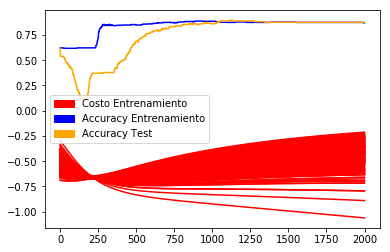

In [211]:
## Funcion para graficar el costo y  accuracy durante cada iteracion ##
helper.training_graph(cost_vect, acc_vect, acc_vect_test)

#### Accuracy con el Test set [Modelo 5]

In [212]:
y_predict = prediccion(X_test_features, modelo_4_theta_values, True)

In [213]:
print('Accuracy:',accuracy_score(y_test, y_predict)* 100 ,'%')

Accuracy: 87.41258741258741 %


#### Matriz de confusion Test Set [Modelo 5]

In [214]:
confusion_matrix(y_test, y_predict)

array([[38, 15],
       [ 3, 87]], dtype=int64)

In [215]:
print('precision: ',precision_score(y_test, y_predict))

print('recall: ', recall_score(y_test, y_predict))

precision:  0.8529411764705882
recall:  0.9666666666666667


# Comparacion de Modelos
Es importante llevar un registro de los resultados de nuestros modelos y los hyperparametros que utilizamos, para ir comparando y ajustando los modelos. En nuestra función de gradient descent esta implementado un registro a bitacora, que almacena cada ejecucion de la funcion.

Este registro almacena datos que nos van a servir para comprar los modelos y tambien almacena los valores theta del modelo, por lo que podemos guardar los modelos y utlizarlos despues.
A continuacion vamos a desplegar en la siguiente celda y nos va ayudar a tomar una decisión de cual es el mejor modelo.

Es recomendable que, luego de analizar los resultados del registro ejecutemos de nuevo alguno de los modelos cambiando los hyperparametros o numero de ejemplos y ver con cuales obtenemos mejores resultados.

Podemos ejecutar la funcion `helper.guardar_log_book(log_book)` para almacenar en disco los modelos.

Para el ultimo paso donde exportamos el modelo debemos utilizar la funcion `helper.filter_log_book(log_book, nombre_modelo)` para obtener el mejor modelo y exportalo.

In [311]:
helper.print_log_book(log_book)

,Nombre Modelo,Numero de features,Numero de ejemplos,Alpha,Numero de Iteraciones,Accuracy Training,Accuracy Test,F1 score Test,Precision Test,Recall Test
0,modelo_1_131752473363,5,150,0.010,500,0.686667,0.664336,0.789474,0.652174,1.000000
1,modelo_1_132034622799,5,150,0.010,500,0.906667,0.874126,0.906250,0.852941,0.966667
2,modelo_2_132039593654,3,400,0.050,1000,0.907500,0.874126,0.906250,0.852941,0.966667
3,modelo_5_132042169998,5,460,0.005,2000,0.882609,0.860140,0.891304,0.872340,0.911111
4,modelo_4_132042578184,5,460,0.005,2000,0.619565,0.629371,0.772532,0.629371,1.000000
5,modelo_4_132042262012,5,460,0.005,2000,0.619565,0.629371,0.772532,0.629371,1.000000
6,modelo_3_132043279118,4,460,0.020,1500,0.882609,0.860140,0.897959,0.830189,0.977778
7,modelo_4_132043291832,5,460,0.030,1000,0.886957,0.874126,0.906250,0.852941,0.966667
8,modelo_5_132043126278,5,460,0.005,2000,0.869565,0.874126,0.906250,0.852941,0.966667
9,modelo_1_132049520640,5,150,0.010,2000,0.913333,0.860140,0.896907,0.836538,0.966667


### Guardando la bitacora

In [312]:
helper.guardar_log_book(log_book)

## Exportar el modelo

Vamos a exportar el modelo para poder hacer deploy, ** el modelo exportado debe tener las cinco primeras feautures **. Por lo cual de todos tus experimentos, selecciona el mejor modelo que cumpla con usar las 5 features ya mencionadas.

Selecciona tu mejor modelo:

### Seleccionamos el mejor modelo

Para seleccionar un modelo utilizamos la funcion `helper.filter_log_book()`.

Esta funcion recibe de parametros la bitacora y el nombre del modelo que elegiste como el mejor

`helper.filter_log_book(log_book, <nombre de nuestro mejor modelo>)`

In [323]:
### INICIO: TU CODIGO AQUI:  (~1 linea)###
modelo = helper.filter_log_book(log_book, 'modelo_1_132100579662')

print(modelo)

[-0.1634648059745372, -0.4824464897175293, 0.1843360280956183, -1.421926689816284, -0.004327445462714156, 2.1688465665748455]


Se va a utilizar el siguiente codigo para guardar el modelo elegido en un archivo.

Esto genera 2 archivos, en un archivo _model.csv se tienen los parametros de el modelo elegido.

El segundo archivo llamado _momentos.csv guarda la media y desviacion estandar de cada features, esto sera utilizado
en la aplicacion hecha por el profesor para aplicar normalizacion al realizar predicciones.

No hay que cambiar nada de codigo, solo hay que ejecutar la celda para exportar nuestro modelo y luego enviar los archivos .csv al profesor

In [326]:
import csv

def exportar_modelo(model,carnet):
    norm_std, norm_media = helper.get_normalizacion_vales(X_train[:,0:5])
    with open(carnet + '_model.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(model)
        
    with open(carnet + '_momentos.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(norm_std)
        filewriter.writerow(norm_media)
        
    print('El modelo ha sido exportado [',csvfile.name,']')
    
exportar_modelo(modelo,carnet)

El modelo ha sido exportado [ 20150066_momentos.csv ]


<img src="images/ai_cancer.png" width="700">

# Una vez elegido y exportado tu modelo , debes enviar los archivos .csv resultantes al profesor por correo